<a href="https://colab.research.google.com/github/amannin2/Machine-Learning/blob/main/Machine_Learning_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading Python Libraries



In [1]:
%%capture
import pandas as pd     
import numpy as np

# for normalization  
from sklearn import preprocessing

# for visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# for Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# for data imbalance, SMOTE
from imblearn.over_sampling import SMOTE
from scipy import stats

# to calculate the performance of the models
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

### Installing RDKit Module

In [2]:
import sys
!time pip install rdkit-pypi

     |████████████████████████████████| 19.7 MB 30.1 MB/s 

real	0m8.829s
user	0m5.320s
sys	0m0.972s


In [3]:
try:
  from rdkit import Chem
  from rdkit.Chem import Draw
  from rdkit.Chem.Draw import IPythonConsole
except ImportError:
  print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
  exit()

### Get Data

In [4]:
# load the training data and save it in the variable "train"
train=pd.read_csv('https://raw.githubusercontent.com/elizabeththrall/MLforPChem/main/MLforvibspectroscopy/Data/binary_train.csv',index_col=0)
# load the test data and save it in the variable "test"
test=pd.read_csv('https://raw.githubusercontent.com/elizabeththrall/MLforPChem/main/MLforvibspectroscopy/Data/binary_test.csv',index_col=0)

In [5]:
# display the contents of the variable "train"
train

,SMILES,name,label,500,502,504,506,508,510,512,514,516,518,520,522,524,526,528,530,532,534,536,538,540,542,544,546,548,550,552,554,556,558,560,562,564,566,568,570,572,...,3922,3924,3926,3928,3930,3932,3934,3936,3938,3940,3942,3944,3946,3948,3950,3952,3954,3956,3958,3960,3962,3964,3966,3968,3970,3972,3974,3976,3978,3980,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
0,COC1OCCO1,2-methoxy-13-dioxolane,0,0.000051,0.000051,0.000052,0.000052,0.000053,0.000053,0.000054,0.000054,0.000055,0.000056,0.000057,0.000057,0.000058,0.000059,0.000060,0.000062,0.000063,0.000064,0.000065,0.000066,0.000068,0.000069,0.000070,0.000071,0.000072,0.000073,0.000074,0.000075,0.000076,0.000077,0.000077,0.000077,0.000078,0.000078,0.000077,0.000077,0.000077,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
1,CCCCCC=O,hexanal,1,0.000121,0.000126,0.000131,0.000136,0.000141,0.000146,0.000151,0.000155,0.000159,0.000163,0.000166,0.000169,0.000171,0.000172,0.000172,0.000172,0.000171,0.000169,0.000166,0.000163,0.000159,0.000155,0.000150,0.000146,0.000141,0.000135,0.000130,0.000125,0.000120,0.000115,0.000111,0.000106,0.000102,0.000097,0.000093,0.000090,0.000086,...,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
2,CC1CCC(C)C1C,1R2R3S-123-trimethylcyclopentane,0,0.000013,0.000013,0.000013,0.000013,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000013,0.000013,...,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013
3,c1cn[se]c1,12-selenazole,0,0.000243,0.000244,0.000245,0.000246,0.000248,0.000249,0.000251,0.000254,0.000256,0.000259,0.000262,0.000266,0.000270,0.000274,0.000278,0.000283,0.000288,0.000294,0.000300,0.000306,0.000313,0.000320,0.000328,0.000336,0.000344,0.000353,0.000363,0.000372,0.000383,0.000394,0.000405,0.000416,0.000429,0.000441,0.000454,0.000467,0.000480,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
4,CCC(C)=CC(C)C,3E-24-dimethylhex-3-ene,0,0.000053,0.000053,0.000054,0.000054,0.000054,0.000054,0.000054,0.000055,0.000055,0.000056,0.000056,0.000057,0.000058,0.000058,0.000059,0.000060,0.000062,0.000063,0.000064,0.000065,0.000067,0.000068,0.000069,0.000070,0.000072,0.000073,0.000074,0.000075,0.000075,0.000076,0.000076,0.000076,0.000075,0.000075,0.000074,0.000073,0.000071,...,0.000014,0.000014,0.000014,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0

### Plotting Data

In [6]:
# change the index values below to pick molecules with and without a carbonyl
idx_hasCarbonyl=1
idx_notCarbonyl=0
# get the data for the two molecules
hasCarbonyl=train.set_index('name').iloc[idx_hasCarbonyl,3:]
notCarbonyl=train.set_index('name').iloc[idx_notCarbonyl,3:] 
# plot the spectra
fig = go.Figure()
fig.add_trace(go.Scatter(x=hasCarbonyl.index, y=hasCarbonyl, name=hasCarbonyl.name,mode='markers'))
fig.add_trace(go.Scatter(x=notCarbonyl.index, y=notCarbonyl,name=notCarbonyl.name,mode='markers'))
fig.update_layout(title='Intensities over frequency',title_x=0.5)

### Data Processing

#### Normalization

In [7]:
# define a function to perform min-max normalization
def df_normalize(df,i=3):
  """
  apply min-max_scaler to each rows
  since min-max scaler originally applies to columns, 
  we will use transposed data and then update the data with transposed result
  """
  min_max_scaler = preprocessing.MinMaxScaler()
  df.iloc[:,i:] = min_max_scaler.fit_transform(df.iloc[:,i:].T).T

In [8]:
# use the functional to normalize the training and test data
df_normalize(train)
df_normalize(test)

#### Apply Threshold

In [9]:
# change the index values below to pick molecules with and without a carbonyl
idx_hasCarbonyl=1
idx_notCarbonyl=0
# get the data for the two molecules
hasCarbonyl=train.set_index('name').iloc[idx_hasCarbonyl,3:]
notCarbonyl=train.set_index('name').iloc[idx_notCarbonyl,3:] 
# plot the spectra
fig = go.Figure()
fig.add_trace(go.Scatter(x=hasCarbonyl.index, y=hasCarbonyl, name=hasCarbonyl.name,mode='markers'))
fig.add_trace(go.Scatter(x=notCarbonyl.index, y=notCarbonyl,name=notCarbonyl.name,mode='markers'))
fig.update_layout(title='Intensities over frequency',title_x=0.5)

In [10]:
# set threshold value
threshold=0.2

In [11]:
# define a function to apply the threshold chosen above
def applyThreshold (dataframe,i=3):
  """
  i is the position of the start of the attributes
  """
  dataframe.iloc[:,i:]=np.where((dataframe.iloc[:,i:]< threshold),0,dataframe.iloc[:,i:])

In [12]:
# use the function to apply the threshold to the training and test data
applyThreshold(train)
applyThreshold(test)

In [13]:
# change the index values below to pick molecules with and without a carbonyl
idx_hasCarbonyl=1
idx_notCarbonyl=0
# get the data for the two molecules
hasCarbonyl=train.set_index('name').iloc[idx_hasCarbonyl,3:] # picked
notCarbonyl=train.set_index('name').iloc[idx_notCarbonyl,3:] # picked 
# plot the spectra
fig = go.Figure()
fig.add_trace(go.Scatter(x=hasCarbonyl.index, y=hasCarbonyl, name=hasCarbonyl.name,mode='markers'))
fig.add_trace(go.Scatter(x=notCarbonyl.index, y=notCarbonyl,name=notCarbonyl.name,mode='markers'))
fig.update_layout(title='Intensities over frequency',title_x=0.5)

#### Split Attribute and Label

In [14]:
# define a function to split the column containing the label from the columns containing the attributes
def splitXY(dataframe,start_X=3,end_X=None,start_Y=2,end_Y=3):
  X=dataframe.iloc[:,start_X:end_X]
  # since current X is a dataframe structure, we use ".value" to only get values
  X=X.values
  Y=dataframe.iloc[:,start_Y:end_Y]
  # since current Y is a dataframe structure, we use ".value" to only get values
  Y=Y.values.ravel()
  # this makes sure all the labels are integers
  Y=Y.astype(float).astype(int)
  return X,Y

In [15]:
# now apply the function to the normalized and thresholded train and test data
X,Y=splitXY(train)
X_test,Y_test=splitXY(test)

#### Data Balancing

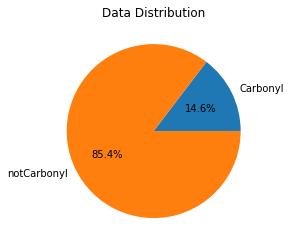

In [16]:
# get the total number of molecules in the training data
total=len(Y)
# determine how many contain a carbonyl
label1=Y.sum()
# find the number without a carbonyl by subtraction
label0=total-label1
# plot the data
data=[label1,label0]
my_labels = 'Carbonyl','notCarbonyl'
plt.pie(data,labels=my_labels,autopct='%1.1f%%')
plt.title('Data Distribution')
plt.show()

#### Synthetic Minority Oversampling Technique (SMOTE)

In [17]:
%%capture
# define SMOTE method
sm = SMOTE(ratio='minority')
# apply SMOTE to the training data
X, Y= sm.fit_sample(X,Y)

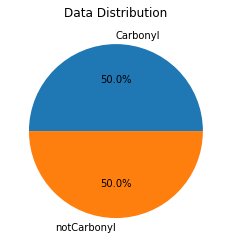

In [18]:
# again determine the number of molecules with and without carbonyl groups and visualize
total=len(Y)
label1=Y.sum()
label0=total-label1
data=[label1,label0]
my_labels = 'Carbonyl','notCarbonyl'
plt.pie(data,labels=my_labels,autopct='%1.1f%%')
plt.title('Data Distribution')
plt.show()

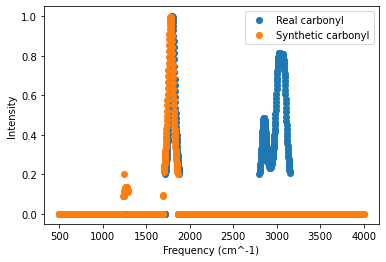

In [19]:
# index values of a real and synthetic carbonyl (you can change these values to see other spectra)
idx_realCarbonyl=1 # this selects the molecule in row 1 of the training data (hexanal)
idx_synCarbonyl=len(train) # this selects the first synthetic carbonyl spectrum
# get the data for the two molecules
spectrum_realCarbonyl=X[idx_realCarbonyl,:]
spectrum_synCarbonyl=X[idx_synCarbonyl,:]
# get the frequencies for plotting
frequencies=range(500,4002,2)
# generate the plot
plt.plot(frequencies,spectrum_realCarbonyl,"o",label="Real carbonyl") 
plt.plot(frequencies,spectrum_synCarbonyl,"o",label="Synthetic carbonyl")
plt.legend(loc="upper right")
plt.xlabel("Frequency (cm^-1)")
plt.ylabel("Intensity")
plt.show()

### Building Machine Learning Models

#### Decision Tree Model

In [20]:
# use the Decision Tree algorithm with the default parameters
dt_clf=DecisionTreeClassifier()
# fit the model using the training dataset
dt_clf.fit(X,Y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### Random Forest Model

In [21]:
# use the Random Forest algorithm with the default parameters
rf_clf=RandomForestClassifier()
# fit the model using the training dataset
rf_clf.fit(X,Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### KNN Model

In [22]:
# import KNN model 
from sklearn.neighbors import KNeighborsClassifier

# create instance of KNN model
neigh = KNeighborsClassifier()

# fit the model using the training dataset
neigh.fit(X, Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

#### Naive-Bayes Model

In [23]:
# import Naive-Bayes model tools
from sklearn.naive_bayes import MultinomialNB

# create instance of Naive-Bayes Model
gnb = MultinomialNB()

# fit the model using the training dataset
gnb.fit(X,Y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### SVM Model

In [24]:
# import SVM model tools
from sklearn import svm

# create instance of SVM model
clf_svm = svm.SVC()

# fit the model using the training dataset
clf_svm.fit(X,Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Neural-Network Model

In [25]:
# import neural network model tools
from sklearn.neural_network import MLPClassifier

# create instance of neural network model
nn = MLPClassifier()

# fit the model using the training dataset
nn.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### Testing Machine Learning Models

#### Test the Decision Tree Model

In [26]:
# use the fitted Decision Tree model to predict the labels (with or without carbonyl) for the test dataset
Y_pred=dt_clf.predict(X_test)

In [27]:
# determine the accuracy, sensitivity, and specificity by comparing the predicted labels to the actual labels
dt_accuracy=np.round(accuracy_score(Y_test,Y_pred),2)
dt_sensitivity=np.round(recall_score(Y_test,Y_pred),2)
dt_specificity=np.round(recall_score(Y_test,Y_pred,pos_label=0),2)

# display the accuracy, sensitivity, and specificity
print("Accuracy: "+str(dt_accuracy)+" Sensitivity: "+str(dt_sensitivity)+" Specificity: "+str(dt_specificity))

Accuracy: 0.97 Sensitivity: 0.93 Specificity: 0.98


#### Test the Random Forest Model

In [28]:
# use the fitted Random Forest model to predict the labels (with or without carbonyl) for the test dataset
Y_pred=rf_clf.predict(X_test)

In [29]:
# determine the accuracy, sensitivity, and specificity by comparing the predicted labels to the actual labels
rf_accuracy=np.round(accuracy_score(Y_test,Y_pred),2)
rf_sensitivity=np.round(recall_score(Y_test,Y_pred),2)
rf_specificity=np.round(recall_score(Y_test,Y_pred,pos_label=0),2)

# display the accuracy, sensitivity, and specificity
print("Accuracy: "+str(rf_accuracy)+" Sensitivity: "+str(rf_sensitivity)+" Specificity: "+str(rf_specificity))

Accuracy: 0.98 Sensitivity: 1.0 Specificity: 0.98


#### Test the KNN Model

In [30]:
# use the KNN model to predict the labels (with or without carbonyl) for the test dataset
Y_pred=neigh.predict(X_test)

In [31]:
# determine the accuracy, sensitivity, and specificity by comparing the predicted labels to the actual labels
knn_accuracy=np.round(accuracy_score(Y_test,Y_pred),2)
knn_sensitivity=np.round(recall_score(Y_test,Y_pred),2)
knn_specificity=np.round(recall_score(Y_test,Y_pred,pos_label=0),2)

# display the accuracy, sensitivity, and specificity
print("Accuracy: "+str(knn_accuracy)+" Sensitivity: "+str(knn_sensitivity)+" Specificity: "+str(knn_specificity))

Accuracy: 0.97 Sensitivity: 1.0 Specificity: 0.96


#### Test the Naive-Bayes Model

In [32]:
# use the Naive-Bayes model to predict the labels (with or without carbonyl) for the test dataset
Y_pred = gnb.predict(X_test)

In [33]:
# determine the accuracy, sensitivity, and specificity by comparing the predicted labels to the actual labels
nb_accuracy=np.round(accuracy_score(Y_test,Y_pred),2)
nb_sensitivity=np.round(recall_score(Y_test,Y_pred),2)
nb_specificity=np.round(recall_score(Y_test,Y_pred,pos_label=0),2)

# display the accuracy, sensitivity, and specificity
print("Accuracy: "+str(nb_accuracy)+" Sensitivity: "+str(nb_sensitivity)+" Specificity: "+str(nb_specificity))

Accuracy: 0.91 Sensitivity: 1.0 Specificity: 0.88


#### Test SVM Model

In [34]:
# use the SVM model to predict the labels (with or without carbonyl) for the test dataset
Y_pred = clf_svm.predict(X_test)

In [35]:
# determine the accuracy, sensitivity, and specificity by comparing the predicted labels to the actual labels
svm_accuracy=np.round(accuracy_score(Y_test,Y_pred),2)
svm_sensitivity=np.round(recall_score(Y_test,Y_pred),2)
svm_specificity=np.round(recall_score(Y_test,Y_pred,pos_label=0),2)

# display the accuracy, sensitivity, and specificity
print("Accuracy: "+str(svm_accuracy)+" Sensitivity: "+str(svm_sensitivity)+" Specificity: "+str(svm_specificity))

Accuracy: 0.99 Sensitivity: 1.0 Specificity: 0.98


#### Test the Neural Network Model

In [36]:
# use the Naive-Bayes model to predict the labels (with or without carbonyl) for the test dataset
Y_pred = nn.predict(X_test)

In [37]:
# determine the accuracy, sensitivity, and specificity by comparing the predicted labels to the actual labels
nn_accuracy=np.round(accuracy_score(Y_test,Y_pred),2)
nn_sensitivity=np.round(recall_score(Y_test,Y_pred),2)
nn_specificity=np.round(recall_score(Y_test,Y_pred,pos_label=0),2)

# display the accuracy, sensitivity, and specificity
print("Accuracy: "+str(nn_accuracy)+" Sensitivity: "+str(nn_sensitivity)+" Specificity: "+str(nn_specificity))

Accuracy: 0.98 Sensitivity: 0.98 Specificity: 0.98


### FP/FN Group Analysis

In [38]:
# rerun the label prediction (change the line below to specify which model to use)
Y_pred=dt_clf.predict(X_test)

# create new variables to hold the indices (i.e., row number) of all FPs and FNs
fp=[]
fn=[]

# go through all predictions to identify the errors and then determine whether each one is an FP or FN
for i in range (len(Y_test)):
  # identify FPs and store their indices
  if Y_pred[i] != Y_test[i] and Y_test[i] ==0:
       fp.append(i)
  # identify FNs and store their indices
  elif Y_pred[i] != Y_test[i] and Y_test[i]==1:
       fn.append(i)

#### Utilizing RDkit to get molecule structure

In [39]:
# get the SMILES strings
fpmols=test.iloc[fp,0].values 
# get the molecule name
fpmols_name=test.iloc[fp,1].values 

# get the SMILES strings 
fnmols=test.iloc[fn,0].values 
# get the molecule names
fnmols_name=test.iloc[fn,1].values

# get lists of the FP and FN SMILES strings
fp_list = [Chem.MolFromSmiles(smiles) for smiles in fpmols]
fn_list = [Chem.MolFromSmiles(smiles) for smiles in fnmols]

In [40]:
# set molecule names for the FP plot displayed below
for i in range(len(fp_list)):
  mol=fp_list[i]
  mol.SetProp("_Name",fpmols_name[i])

# set molecule names for the FN plot displayed below
for i in range(len(fn_list)):
  mol=fn_list[i]
  mol.SetProp("_Name",fnmols_name[i])

In [41]:
# display a table showing the index, SMILES string, and name of all FPs
print('\033[1m' + 'FP List' + '\033[0m')
test.iloc[fp, 0:2]

FP List


,SMILES,name
29,BC,methylborane
105,F[CrH],chromium-fluoride-hydride
182,[CrH2],chromium-dihydride
210,CN(C)C(=N)N(C)C,1133-tetramethylguanidine


In [42]:
# display a table showing the index, SMILES string, and name of all FNs
print('\033[1m' + 'FN List' + '\033[0m')
test.iloc[fn, 0:2]

FN List


,SMILES,name
23,CC(C)=O,acetone
59,CCCC(=O)N(CC)CC,NN-diethylbutanamide
183,Cc1ccccc1C=O,o-tolualdehyde


##### FP Group

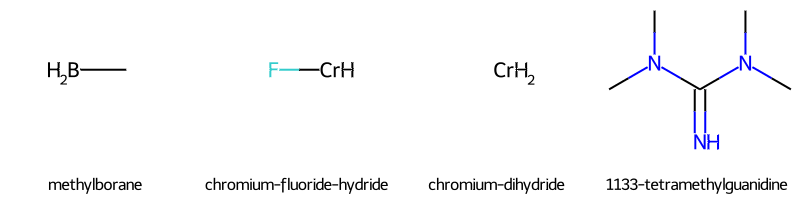

In [43]:
# display the molecular structures of all FPs
img1=Chem.Draw.MolsToGridImage(fp_list,molsPerRow=4,subImgSize=(200,200),legends=[mol.GetProp('_Name') for mol in fp_list])
img1

##### FN Group

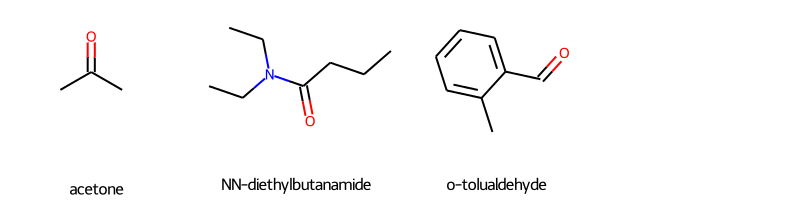

In [44]:
# display the molecular structures of all FNs
img2=Chem.Draw.MolsToGridImage(fn_list,molsPerRow=4,subImgSize=(200,200),legends=[mol.GetProp('_Name') for mol in fn_list])
img2

#### Displaying FN/FP Spectrums

In [45]:
# to display the spectrum of a FP
# in the line below, insert the index value of the molecule you want to see from the table above
fp_idx=78
# then display the figure
fp_mol=test.set_index('name').iloc[fp_idx,3:]
fig = go.Figure()
fig.add_trace(go.Scatter(x=fp_mol.index, y=fp_mol, name=fp_mol.name,mode='markers'))
fig.update_layout(title='Intensities over frequency',title_x=0.5)
fig.update_layout(showlegend=True)

In [46]:
# to display the spectrum of a FN
# in the line below, insert the index value of the molecule you want to see from the table above
fn_idx=137
# then display the figure
fn_mol=test.set_index('name').iloc[fn_idx,3:]
fig = go.Figure()
fig.add_trace(go.Scatter(x=fn_mol.index, y=fn_mol, name=fn_mol.name,mode='markers'))
fig.update_layout(title='Intensities over frequency',title_x=0.5)
fig.update_layout(showlegend=True)

### Assessing Overall Model Performance

In [47]:
# create variables containing the performance metrics for each of the models
acs=[dt_accuracy,rf_accuracy,knn_accuracy,nb_accuracy,svm_accuracy,nn_accuracy]
sens=[dt_sensitivity,rf_sensitivity,knn_sensitivity,nb_sensitivity,svm_sensitivity,nn_sensitivity]
specs=[dt_specificity,rf_specificity,knn_specificity,nb_specificity,svm_specificity,nn_specificity]

In [48]:
# make and display a DataFrame
d = {'Model':['Decision Tree','Random Forest','KNN','Naive-Bayes','SVM','NN'],'Accuracy':acs, 'Sensitivity':sens,' Specificity':specs}
result = pd.DataFrame(data=d)

In [49]:
result

,Model,Accuracy,Sensitivity,Specificity
0,Decision Tree,0.97,0.93,0.98
1,Random Forest,0.98,1.00,0.98
2,KNN,0.97,1.00,0.96
3,Naive-Bayes,0.91,1.00,0.88
4,SVM,0.99,1.00,0.98
5,NN,0.98,0.98,0.98
